In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pandas.tseries.offsets import DateOffset
#from pandas_datareader import data
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime, timedelta

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
# Loading data
file_path = Path("../Datasets/algoData_BTC-USD.csv")
df = pd.read_csv(file_path)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)


In [3]:
# z-scores Features
zScoreFeatures = ['EMAShort_zscore', 'EMALong_zscore',  'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore',
                   'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', "upperBB_zscore", 
                  "2stdBB_zscore", "MACDline_zscore", 'MACDHistogram_zscore','MACDSignal_zscore' ]


# normal Features
normalFeatures = ['EMAShort_normal', 'EMALong_normal',  'RSIline_normal', 'MOMline_normal', 'ROCline_normal',
                   'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', "upperBB_normal", 
                  "2stdBB_normal", "MACDline_normal", 'MACDHistogram_normal','MACDSignal_normal' ]

In [4]:
# Separate the data into labels and features

# Separate the y variable, the labels
#y = df["Signal"].values.reshape(-1,1)
y = df['Signal']

# Separate the X variable, the features
X = df[zScoreFeatures]
#X = df[normalFeatures]

In [5]:
# Split data into training and test datasets

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2014-12-04 00:00:00+00:00


In [6]:
# Select the ending period for the training data with an offset of 145 months
training_end = X.index.min() + DateOffset(months=70)

# Display the training end date
print(training_end)

2020-10-04 00:00:00+00:00


In [7]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
#X_train.tail()

In [8]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
#X_test.head()

In [9]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)

In [10]:
# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [11]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)


In [12]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,
                    index=['Sell', 'Buy'],
                    columns=['Sell', 'Buy'])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [13]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Sell,Buy
Sell,128,239
Buy,137,252


Accuracy Score : 0.5026455026455027
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.35      0.41       367
         1.0       0.51      0.65      0.57       389

    accuracy                           0.50       756
   macro avg       0.50      0.50      0.49       756
weighted avg       0.50      0.50      0.49       756



In [14]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [15]:
# List the most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)
importances_sorted[:]

[(0.08293384597257168, 'RSIline_zscore'),
 (0.08282271944410419, 'ROCline_zscore'),
 (0.07922620614441157, 'SMAline_zscore'),
 (0.07903634515721837, 'MOMline_zscore'),
 (0.0765728233474921, 'lowerBB_zscore'),
 (0.07626676607915417, 'MACDHistogram_zscore'),
 (0.07557208462454353, '2stdBB_zscore'),
 (0.07554525623009957, 'MACDSignal_zscore'),
 (0.07545200443963085, 'EMAShort_zscore'),
 (0.07542046859476079, 'upperBB_zscore'),
 (0.0743754082450636, 'EMALong_zscore'),
 (0.07348414871532234, 'middleBB_zscore'),
 (0.07329192300562713, 'MACDline_zscore')]

<AxesSubplot:xlabel='Date'>

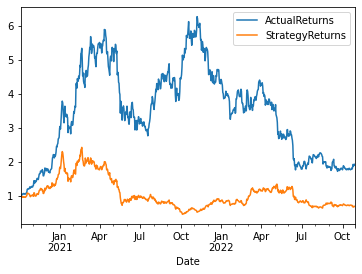

In [16]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = predictions

predictions_df['ActualReturns'] = df['ActualReturns']

# Add the strategy returns to the DataFrame
predictions_df['StrategyReturns'] = predictions_df['ActualReturns'] * predictions_df['Predicted']

# Plot the actual returns versus the strategy returns
(1 + predictions_df[["ActualReturns", "StrategyReturns"]]).cumprod().plot()

In [17]:
del predictions_df['ActualReturns']

predictions_df['cumStrategyReturns'] = (1 + predictions_df['StrategyReturns']).cumprod()

In [18]:
predictions_df

,Predicted,ActualReturns,StrategyReturns,cumRFStrategyReturns
Date,,,,
2020-10-05 00:00:00+00:00,-1.0,-0.017505,0.017505,1.017505
2020-10-06 00:00:00+00:00,-1.0,0.006088,-0.006088,1.011310
2020-10-07 00:00:00+00:00,-1.0,0.023125,-0.023125,0.987924
2020-10-08 00:00:00+00:00,-1.0,0.013629,-0.013629,0.974459
2020-10-09 00:00:00+00:00,-1.0,0.020959,-0.020959,0.954035
...,...,...,...,...
2022-10-26 00:00:00+00:00,-1.0,-0.023331,0.023331,0.682024
2022-10-27 00:00:00+00:00,1.0,0.015258,0.015258,0.692430
2022-10-28 00:00:00+00:00,-1.0,0.010834,-0.010834,0.684928
